# LSTM - vanilla

In [19]:
best_model = "best_model_all_feat_2layers_all_agents.pt"

# best_model = "best_model_all_feat_all_agents.pt"

In [20]:
best_model

'best_model_all_feat_2layers_all_agents.pt'

## Load and prepare data

In [21]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [22]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
# train_data = train_data[::2]
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


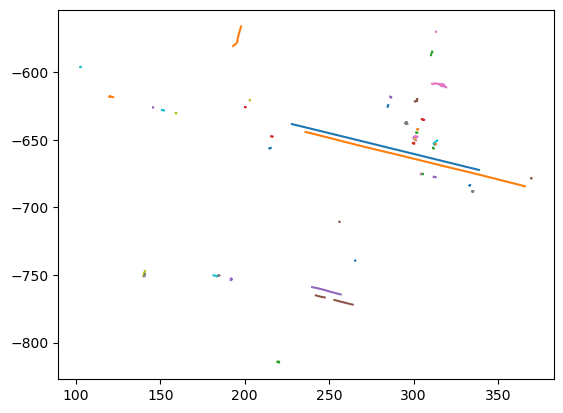

In [23]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [24]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :5].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (50, 60, 2)
        #add the feature of the scene number for each sample
       
 
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
                # future[..., 2:4] = future[..., 2:4] @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1
                # future[:, 2] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future[..., :2] = future[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale
        # hist[..., :2] = hist[..., :2] / self.scale
        # future[..., :2] = future[..., :2] / self.scale

        
        # print("hist's shape", hist.shape)
        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        # hist = hist[...,]
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale
        hist[..., :2] = hist[..., :2] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [25]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0 #why not 10

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [26]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=output_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :self.input_dim] 
       
        x = x.reshape(-1, 50, 50, self.input_dim)[:, 0, :, :]  # (B*A, 50, 5)
        # x = x.reshape(-1, 50, self.input_dim)
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, self.output_dim) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :self.output_dim].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [27]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [28]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=150, patience=15, num_agents = 1):
    """
    Improved training function with better debugging and early stopping
    """
    input_dim = model.input_dim # Historical trajectory input dimension
    output_dim = model.output_dim  # Future trajectory output dimension
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            # print(f"Batch size: {batch.x.shape}")
            pred = model(batch, forcing_ratio=forcing_ratio).view(-1, 60, output_dim)
            # y = batch.y.view(-1, 60, output_dim)
            y = batch.y.view(batch.num_graphs, 60, output_dim)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                # pred = pred.view(-1, 50, 60, output_dim)
                pred = pred.view(batch.num_graphs, 60, output_dim)
                # y = batch.y.view(-1, 50, 60, output_dim)
                # y = batch.y.view(-1, 60, output_dim)
                y = batch.y.view(batch.num_graphs, 60, 2)
                

                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()

                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                # batch_loss = criterion(pred[:, 0, :, :2], y[:, 0, :, :2]).item()
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                

                
                # pred_unnorm = pred[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                # y_unnorm = y[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

                # pred_unnorm = pred.view(-1,num_agents,60,output_dim)[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                # y_unnorm = y.view(-1,num_agents,60,output_dim)[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                pred_unnorm = pred* batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches #all agents 
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            tqdm.tqdm.write(f"Sample input first 3 steps: {sample_input[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [29]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, output_dim = 2, hidden_dim=512)
    model = model.to(device)
    num_agents = 1
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=200,
        num_agents = num_agents
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)(-1, num_agents, 60, model.output_dim)
            y = batch.y.view(-1, num_agents, 60, model.output_dim)
            
            # Unnormalize
            pred = pred[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y[:, 0, :, :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
        
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [ ]:
train_and_evaluate_model()

Epoch:   0%|          | 0/200 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_85741/3794418601.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_85741/3794418601.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_85741/3794418601.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   0%|          | 1/200 [00:19<1:05:02, 19.61s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 188314.0890 | Val MSE 11.1665 | Val MAE 18.8698 | Val MSE 547.1597
Sample pred first 3 steps: [[-3.1520789  4.1664176]
 [-1.5467429  5.3311343]
 [-2.3156488  3.8066468]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]
Validation improved: inf -> 11.166524


Epoch:   1%|          | 2/200 [00:42<1:10:22, 21.33s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 108688.3398 | Val MSE 49.0139 | Val MAE 44.1269 | Val MSE 2401.6819


Epoch:   2%|▏         | 3/200 [01:05<1:13:39, 22.43s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 70566.8639 | Val MSE 580.0808 | Val MAE 163.6111 | Val MSE 28423.9577


Epoch:   2%|▏         | 4/200 [01:28<1:13:59, 22.65s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 54628.8976 | Val MSE 6109.4844 | Val MAE 501.9250 | Val MSE 299364.7266


Epoch:   2%|▎         | 5/200 [01:52<1:14:56, 23.06s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 41015.7616 | Val MSE 64.8630 | Val MAE 33.1526 | Val MSE 3178.2854


Epoch:   3%|▎         | 6/200 [02:15<1:14:24, 23.01s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 33280.2155 | Val MSE 1430.8133 | Val MAE 249.7088 | Val MSE 70109.8560
Sample pred first 3 steps: [[ 0.2755849 15.88982  ]
 [ 4.6662726  7.496135 ]
 [ 3.3146532 -3.3866372]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:   4%|▎         | 7/200 [02:38<1:13:34, 22.88s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 26366.9200 | Val MSE 17.4167 | Val MAE 21.7402 | Val MSE 853.4182


Epoch:   4%|▍         | 8/200 [03:01<1:13:18, 22.91s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 28357.3225 | Val MSE 46.5785 | Val MAE 29.6543 | Val MSE 2282.3475


Epoch:   4%|▍         | 9/200 [03:23<1:12:31, 22.78s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 23196.3685 | Val MSE 29.2064 | Val MAE 27.4555 | Val MSE 1431.1125


Epoch:   5%|▌         | 10/200 [03:46<1:12:25, 22.87s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 22207.2264 | Val MSE 188.5091 | Val MAE 35.2142 | Val MSE 9236.9463


Epoch:   6%|▌         | 11/200 [04:11<1:13:40, 23.39s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 19366.6246 | Val MSE 1513.7996 | Val MAE 193.0198 | Val MSE 74176.1801
Sample pred first 3 steps: [[ -3.9208276   9.205487 ]
 [ -2.0843809  13.108226 ]
 [-19.385746    6.917098 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Sample input first 3 steps: [[-3.41748688e-07  1.43109173e-05  6.39591417e-06 -1.12966054e-05
   2.33426189e+00]
 [-2.32525835e-07  1.40127395e-05  6.39591417e-06 -1.12966054e-05
   2.33426213e+00]
 [-1.77852527e-07  1.37678999e-05 -9.72734483e-07 -4.35880975e-06
   2.33426237e+00]]


Epoch:   6%|▌         | 12/200 [04:30<1:09:34, 22.21s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 18155.3653 | Val MSE 52.8365 | Val MAE 33.6065 | Val MSE 2588.9880


Epoch:   6%|▋         | 13/200 [04:52<1:08:44, 22.06s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 18339.9084 | Val MSE 613.8317 | Val MAE 88.9525 | Val MSE 30077.7555


Epoch:   7%|▋         | 14/200 [05:15<1:09:16, 22.34s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 15277.6654 | Val MSE 386.9674 | Val MAE 99.5486 | Val MSE 18961.4032


# Final Pred

In [68]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, hidden_dim=512).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm[...,:2] * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_5_out.csv', index=True)

In [69]:
output_df.head()

,x,y
index,,
0,5426.052734,1467.540771
1,5426.041992,1467.670532
2,5426.288086,1467.650269
3,5426.220215,1467.730713
4,5426.110352,1467.654907
